# MS3 - Load in data pipeline
Authors: Harry Li, Yunxi Li, John Jun, Valentin Badea

## Installs and Imports

Here we will load necessary packages and any overhead installs required for the data access

In [14]:
# Import libraries
# Core Python Libraries
import os
import sys
import json
import warnings
import gc
import joblib
from types import SimpleNamespace
from operator import itemgetter
from abc import abstractmethod
from tqdm import tqdm
import glob
import zipfile

# Core Data manipulation Libraries
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, ConstantInputWarning

# Visualization Library
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

# Spatial Data Processing
import spatialdata as sd  # Manage multi-modal spatial omics datasets
import anndata as ad  # Manage annotated data matrices in memory and on disk
import scanpy as sc  # For analyzing single-cell data, especially for dimensionality reduction and clustering.
from skimage.measure import regionprops  # Get region properties of nucleus/cell image from masked nucleus image
import h5py  # For handling HDF5 data files

# Frameworks for ML and DL models
# import torch
# import timm  # timm: A library to load pretrained SOTA computer vision models (e.g. classification, feature extraction, ...)
# from sklearn.linear_model import Ridge  # Regression model

# Additional packages
import dask.array as da
import xarray as xr
from spatial_image import SpatialImage

## Data Loading

Loads in and stores the data objects in this note book for easier acess, might require some large memory

In [ ]:
sdata = sd.read_zarr('raw/UC6_I.zarr/UC6_I.zarr')

/home/b-evelyntong/hl/ac109_project/.venv/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


## Data Exploration

Let us explore what this object contains:

In [16]:
sdata

SpatialData object, with associated Zarr store: /home/b-evelyntong/hl/ac109_project/raw/UC6_I.zarr/UC6_I.zarr
├── Images
│     ├── 'HE_nuc_original': DataArray[cyx] (1, 20000, 20992)
│     └── 'HE_original': DataArray[cyx] (3, 20000, 20992)
└── Tables
      ├── 'anucleus': AnnData (223790, 460)
      └── 'cell_id-group': AnnData (308924, 0)
with coordinate systems:
    ▸ 'global', with elements:
        HE_nuc_original (Images), HE_original (Images)

The object `sdata` contains two types of instances: `Images` and `Tables`.

The `Image` instance named `'HE_original'` is a 3d array with dimension $(3, 20000, 20992)$. Therefore it must be an RGB image (3 channels on the first dimension) with dimension $20000 \times 20992$. Let's see how it looks like:

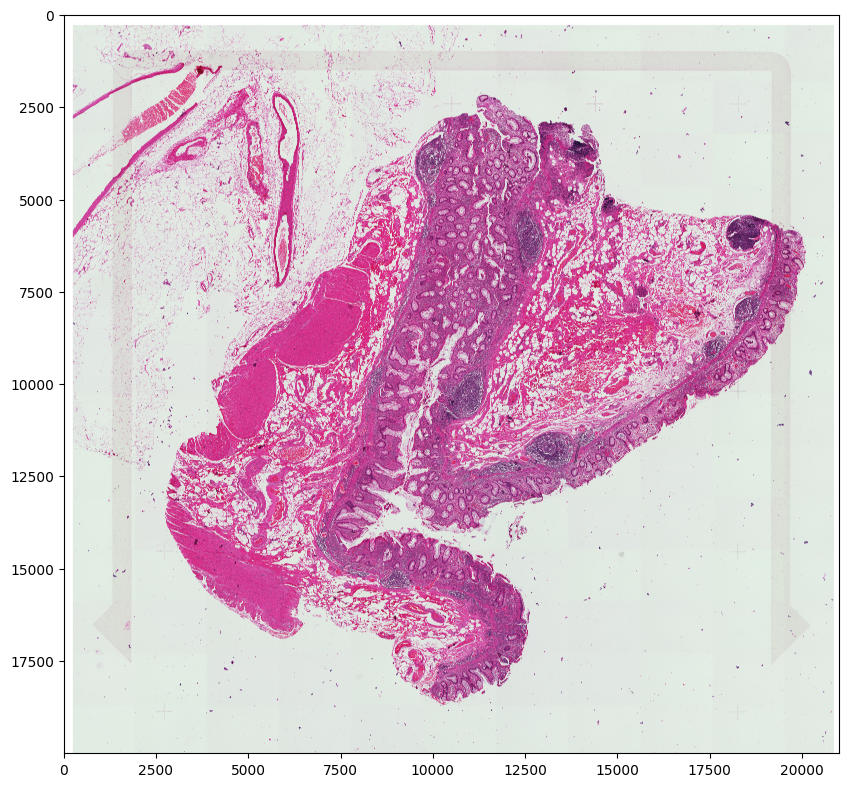

In [17]:
plt.figure(figsize=(10, 10))
transpose_image = np.transpose(sdata.images['HE_original'].to_numpy(), (1, 2, 0))
plt.imshow(transpose_image)
plt.show()

In [ ]:
print("Image resolution is",transpose_image.shape[0]*transpose_image.shape[1], "pixels")

Image resolution is 419840000 pixels


Let us now look at the entry `'HE_nuc_original'` in the `Image` instance. The description of `sdata` tells us that this is a 3d array with the same width and length as `'HE_original'` and only one channel for the pixel value.

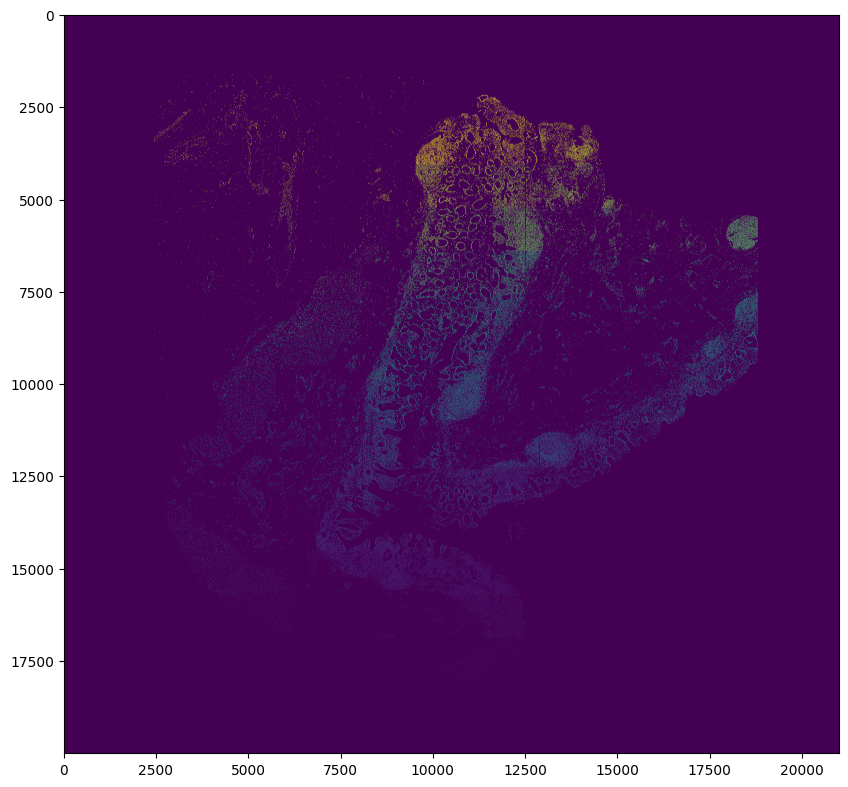

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(sdata.images['HE_nuc_original'].to_numpy()[0,:,:])
plt.show()

This is not super clear! Let's look at a smaller area of the image and compare this output with the original image

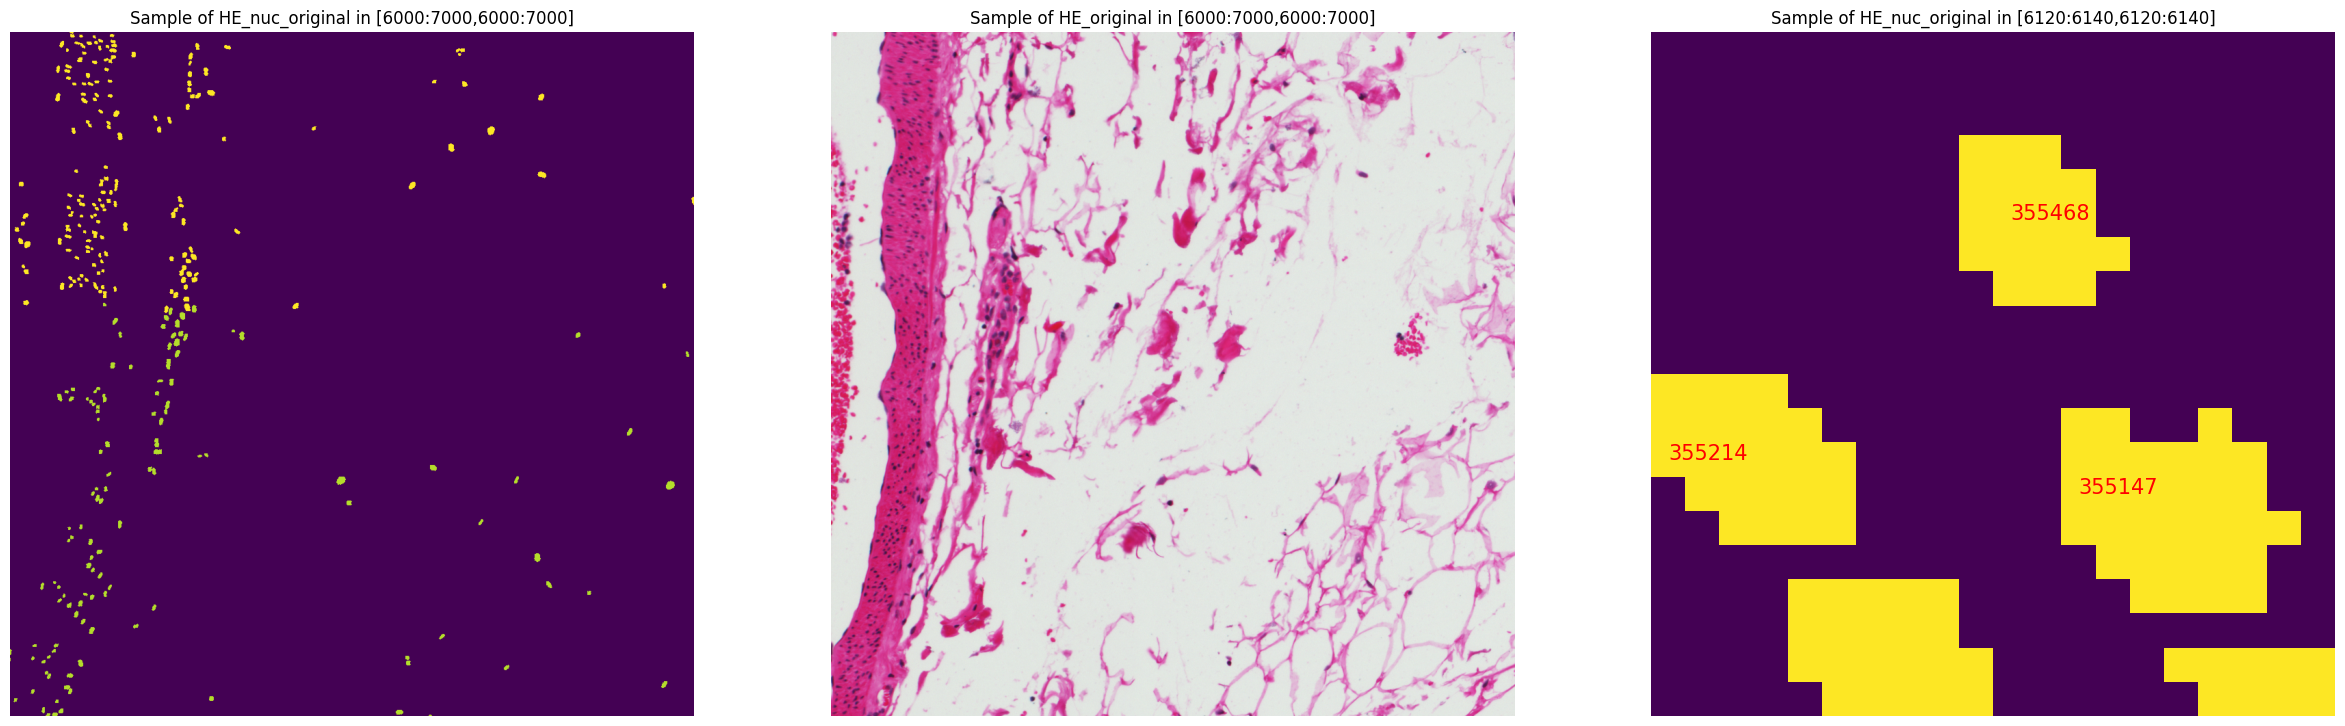

In [ ]:
he_nuc_original_sample = sdata["HE_nuc_original"].to_numpy()[0,6000:7000,6000:7000]
fig,ax = plt.subplots(1,3,figsize=(30,10))
ax[0].imshow(he_nuc_original_sample)
ax[0].axis("off")
ax[0].set_title("Sample of HE_nuc_original in [6000:7000,6000:7000]")
ax[1].imshow(transpose_image[6000:7000,6000:7000])
ax[1].axis("off")
ax[1].set_title("Sample of HE_original in [6000:7000,6000:7000]")
ax[2].imshow(he_nuc_original_sample[240:260,120:140]) #plotting the image in [6120:6140]
ax[2].axis("off")
ax[2].text(0,12,he_nuc_original_sample[240 + 12,120 + 0],fontsize=15,color = "red")
ax[2].text(10,5,he_nuc_original_sample[240+5,120 + 10],fontsize=15,color = "red")
ax[2].text(12,13,he_nuc_original_sample[240+12,120 + 13],fontsize=15,color = "red")
ax[2].set_title("Sample of HE_nuc_original in [6120:6140,6120:6140]")
plt.show()

This is now much clearer! The array `'HE_nuc_original'` is a mask that indicates the location of the cell nuclei in the image. The pixel value is either set to be 0 if there is no cell or equal to the cell nuclei id. It would be tempting to look at the maximum value of nuclei id in the array to infer the number of cells in the image, but it would be a hazardous process, since we don't know if the nuclei id are spaced incrementally...

Now let us look at the instance `Table` in `sdata`:

In [ ]:
sdata.tables["anucleus"]

AnnData object with n_obs × n_vars = 223790 × 460
    obs: 'cell_id'
    var: 'gene_symbols'
    obsm: 'spatial'
    layers: 'counts'

In [ ]:
sdata.tables["anucleus"].X

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [1.5781854, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 2.7963428, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [2.2091649, 0.       , 2.4690154, ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

The X dataframe is the normalized gene expression matrix.

The table `anucleus`contains the cell ids, which we can access with the key `obs`:

In [ ]:
sdata.tables["anucleus"].obs.head()

,cell_id
92,92
93,93
94,94
95,95
97,97


In [ ]:
print("There are", len(sdata.tables["anucleus"].obs), "cells identified and quantified in the image")

There are 223790 cells identified in the image


The `anucleus` table contains the key `var` which is associated with the genes measured in this experiment:

In [ ]:
sdata.tables["anucleus"].var.head()

,gene_symbols
A2M,A2M
ACP5,ACP5
ACTA2,ACTA2
ADAMTSL3,ADAMTSL3
AFAP1L2,AFAP1L2


In [ ]:
print("There are", len(sdata.tables["anucleus"].var),"genes measured in this experiment.")

There are 460 genes measured in this experiment.


Then, we find that the table `anucleus` contains a key `obsm`, itself containing a unique key `spatial` which stores the following array:

In [ ]:
print(sdata.tables["anucleus"].obsm["spatial"])
print("This array has shape",sdata.tables["anucleus"].obsm["spatial"].shape)

[[25120.23969466  4197.8610687 ]
 [25087.67387033  3928.96660118]
 [25383.72636816  4410.71475954]
 ...
 [50715.87037037 54110.51851852]
 [50528.79213483 53837.87359551]
 [50431.78014184 54715.05319149]]
This array has shape (223790, 2)


In [ ]:
x,y = np.where(sdata.images["HE_nuc_original"].to_numpy()[0,:,:] == 92)
x_0,y_0 = np.mean(x),np.mean(y)

In [ ]:
25120/x_0,4197/y_0

(np.float64(1.3850639917717291), np.float64(0.37930213440438804))

The length of the array `spatial` is exactly the number of cells in the image. According to documentation, this dataframe seems to record the "spatial coordinates of the center of the nucleus ... based on the registered images (DAPI)", however we notice that the max, or dimension of this dataframe is ~50000 which is larger than the dimensions of the pixel intensity dataframe (`'HE_original'` and `'HE_nuc_original'`). We wondered if the organizer did some aspect rescaling for this data to obtain `'HE_nuc_original'` but the result didn't really support our hypothesis (we would've expected the two values to be the same, which is scaling factor)

We also notice that in the documentations in the original challenge, `obsm['spatial']` was overwritten during the processing with the output of some function on `'HE_nuc_original'`, which as we have seen above, is the mask of each cell. So for our purpose here we will omit the information provided in `obsm['spatial'`] as we technically have all the data we need to train our model.


The `counts` table in the `anucleus` data is an array containing the RNA counts cell by cell for every gene studied.

In [ ]:
print(sdata.tables["anucleus"].layers["counts"].shape)
print(sdata.tables["anucleus"].layers["counts"])

(223790, 460)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 2 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [3 0 4 ... 0 0 0]]


Finally, we look at the table `"cell_id_group"` and its key `obs`. It contains a dataframe reporting for every cell_id in the image if it is used for training or testing.

In [ ]:
sdata.tables["cell_id-group"].obs

,cell_id,group
0,92,train
1,93,train
2,94,train
3,95,train
5,97,train
...,...,...
430002,312552,test
430005,312566,test
430007,312583,test
430010,312592,test


Here we explored just 1 of the 8 paired (image, transcriptome) datasets provided, note DC1 is a test dataset. We use sd.read_zarr(zarr_file_path) to load each file into a "Spatial Data" object in the notebook.

We can query this object via []. Both 'HE_nuc_original' and 'HE_original' returns image objects, where nuc returns 1 channel and the other one 3 channels. Probably nuc refers to the presegmented, nucleus mask for each histology image (so we can use it for our model if needed). Next, we can query 'anucleus', which returns an AnnData obeject, with 'obs', 'var', 'obsm', 'layers' attributes. 'obs' is the cell ids, 'var' is the genes (just ~400 in this case, normally there'd be ~20000, they either subsetted due to disease significance or used a sequencing method that only produced this many). 'layers' contains the 'counts' variable which seems to be the raw count of each gene inside each cell. Also, querying 'X' gives us a n_cell by n_gene matrix, which is the expression matrix that will be our output.

Querying for 'cell_id-group' gives us the test-train split for the cells in this sample. We will use this to construct our train and test datasets.

Above, we also visualized the cells on a spatial dimension. Note the two strips are not test cells, but probably data intensionally leftout for other reasons. The test groups are the square-ish patches in the plot, the image of which is plotted below the blue dot plot.

We aim to design a model that takes in the pixel values of the each cell and output their expression value (normalized) for the genes selected.

For length sake, we omit our analyses for the rest of the 8 datasets (which had the same structure), but for our project, we will repeat both the EDA and the pre-processing (which is really just normalizing the intensity data) for the other datasets as well

## Normalizing the intensity data

In [ ]:
sdata['HE_original'].to_numpy()

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

In [ ]:
def normalize_he_original(sdata, image_key='HE_original', new_key='HE_normalized'):
    """
    takes in the sdata object, pulls the image object out, normalizes each pixel
    by dividing over 255, store it back into sdata, then returns the new sdata object.
    """
    # extract original image
    original = sdata.images[image_key]

    # convert to NumPy, normalize, then convert back
    intensity_image = np.transpose(original.to_numpy(), (1, 2, 0))
    normalized = intensity_image / 255.0
    normalized_cyx = np.transpose(normalized, (2, 0, 1))
    normalized_dask = da.from_array(normalized_cyx, chunks="auto")

    # build new DataArray
    da_norm = xr.DataArray(
        normalized_dask,
        dims=("c", "y", "x"),
        coords={
            "c": original.coords["c"],
            "y": original.coords["y"],
            "x": original.coords["x"]
        },
        attrs=original.attrs
    )

    # wrap as SpatialImage
    sdata.images[new_key] = SpatialImage(da_norm)

    return sdata

In [ ]:
sdata = normalize_he_original(sdata)
sdata["HE_normalized"].to_numpy()

## Discuss any potential data issues outlined in the MS2 spec and how these issues have been resolved
- Missingness \
We investigated 2 types of missingness in our data. Firstly, the DC1 sample does not have spatial transcriptomics data. Secondly, there exists held out regions in each set of samples where spatial transcriptomics data is not available, with UC7 I sample having a larger such region. We have concluded that these regions were intentionally held out 1) for contest testing purposes, and 2) for the model to generalize better in potential downstream fine tuning cases where transcriptomic data that are not spatially adjacent. In reality, spatial transcriptomics is very expensive to conduct. It is often unrealistic to get spatial transcriptomics data for every spot on a whole slide image. Therefore, these held-out regions do not introduce significant problems or NAs to our project.

- Data imbalance \
For this dataset to be representative, we would like it to represent spatial organizations of the colon at different statuses, including normal and diseased. To make sure that the dataset includes a comprehensive sample, we further investigated the subtypes of conditions where the samples are from. The dataset has 6 sets of ulcerative colitis (UC) IBD subtype and 2 diverticulitis (DC) disease. UC is the most common subtype of IBD and are good representations of how IBD disease can affect the spatial organization of the colon tissue. DC disease, on the other hand, does not have a substantial effect on the spatial organization of the tissue. Therefore, the DC samples can serve as a representation of the normal colon tissue. Given that our main research aim is related to treating IBD, we consider it sufficient to have most of our dataset focusing on the disease state, learning the image feature representations of the disease affected colon tissue, while also having a small subsample of the normal colon tissue to learn from.

- Feature scaling \
The images in our dataset come with different intensities and the gene expression values may vary significantly between genes. Following the convention of scaling RGB images, we divided the image values by 255 for each pixel to have values between 0 and 1. Then, we incorporated the normalized intensities into the spatial data object for easier accessing and further processing. For the spatial transcriptomics data, we normalized the gene expression values for each gene — which is already done in the datasets provided.

## Citation
Broad Institute autoimmune disease. CrunchDAO Docs V3. (2024a). https://docs.crunchdao.com/competitions/competitions/broad-institute-autoimmune-disease